# Electricity Consumption Forecasting Project

## Overview
This notebook forecasts household electricity consumption using time-series aware machine learning models.

**Dataset**: `household_power_consumption.csv`  
**Target**: `Global_active_power` (kilowatts)  
**Models**: Random Forest, XGBoost, Linear Regression, Decision Tree

## Key Improvements in This Version
- Fixed datetime parsing (removed invalid `format='mixed'`)
- Consolidated data cleaning into single section
- Implemented chronological train/test split for time-series
- Fixed shape mismatch bugs in predictions
- Added data diagnostics and drift detection
- Improved feature engineering with lag features

## 1. Import Libraries

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn import tree
import joblib
import warnings
warnings.filterwarnings('ignore')

# Set plot style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print("✅ All libraries imported successfully")

✅ All libraries imported successfully


## 2. Data Loading and Initial Inspection

In [5]:
# Load dataset with semicolon separator
df = pd.read_csv('household_power_consumption.csv', sep=';', low_memory=False)

print(f"Dataset shape: {df.shape}")
print(f"\nColumn names:\n{df.columns.tolist()}")
print(f"\nFirst few rows:")
df.head()

Dataset shape: (2075259, 9)

Column names:
['Date', 'Time', 'Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']

First few rows:


,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


## 3. Data Cleaning and Preprocessing (Consolidated)

In [6]:
# Step 1: Replace '?' with NaN
df.replace('?', np.nan, inplace=True)

# Step 2: Convert numeric columns
cols_to_convert = ['Global_active_power', 'Global_reactive_power', 'Voltage',
                   'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']

for col in cols_to_convert:
    df[col] = pd.to_numeric(df[col], errors='coerce')

print(f"Missing values before cleaning:\n{df.isnull().sum()}")

# Step 3: Drop rows with missing values
df.dropna(inplace=True)

print(f"\n✅ Shape after cleaning: {df.shape}")
print(f"Missing values after cleaning: {df.isnull().sum().sum()}")

Missing values before cleaning:
Date                         0
Time                         0
Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

✅ Shape after cleaning: (2049280, 9)
Missing values after cleaning: 0
Missing values after cleaning: 0


## 4. DateTime Processing (FIXED)

In [7]:
# Create datetime index (FIXED: removed invalid format='mixed')
df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], dayfirst=True, errors='coerce')

# Drop any rows where datetime parsing failed
df = df.dropna(subset=['Datetime'])

# Set as index and sort
df.set_index('Datetime', inplace=True)
df.sort_index(inplace=True)

# Drop original date/time columns and any 'index' column
df.drop(columns=['Date', 'Time', 'index'], errors='ignore', inplace=True)

print(f"✅ DateTime index created")
print(f"Date range: {df.index.min()} to {df.index.max()}")
print(f"Total duration: {(df.index.max() - df.index.min()).days} days")

✅ DateTime index created
Date range: 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Total duration: 1441 days


## 5. Data Diagnostics

In [9]:
# Check dataset recency
last_reading = df.index.max()
days_since_last = (pd.Timestamp.today() - last_reading).days

print("📊 Dataset Diagnostics")
print(f"First reading: {df.index.min()}")
print(f"Last reading:  {last_reading}")
print(f"Days since last reading: {days_since_last}")
print(f"Total records: {len(df):,}")

if days_since_last > 365:
    print(f"⚠️ WARNING: Dataset is {days_since_last} days old. Consider using recent data for production forecasting.")
elif days_since_last > 180:
    print(f"⚠️ CAUTION: Dataset is {days_since_last} days old. Validate model performance on recent data.")
else:
    print("✅ Dataset is relatively recent.")

# Display last 10 records
print("\nLast 10 records:")
df.tail(10)

📊 Dataset Diagnostics
First reading: 2006-12-16 17:24:00
Last reading:  2010-11-26 21:02:00
Days since last reading: 5457
Total records: 2,049,280
⚠️ WARNING: Dataset is 5457 days old. Consider using recent data for production forecasting.

Last 10 records:


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Datetime,,,,,,,
2010-11-26 20:53:00,0.944,0.0,238.72,4.0,0.0,0.0,0.0
2010-11-26 20:54:00,0.946,0.0,239.31,4.0,0.0,0.0,0.0
2010-11-26 20:55:00,0.946,0.0,239.74,4.0,0.0,0.0,0.0
2010-11-26 20:56:00,0.942,0.0,239.41,4.0,0.0,0.0,0.0
2010-11-26 20:57:00,0.946,0.0,240.33,4.0,0.0,0.0,0.0
2010-11-26 20:58:00,0.946,0.0,240.43,4.0,0.0,0.0,0.0
2010-11-26 20:59:00,0.944,0.0,240.00,4.0,0.0,0.0,0.0
2010-11-26 21:00:00,0.938,0.0,239.82,3.8,0.0,0.0,0.0
2010-11-26 21:01:00,0.934,0.0,239.70,3.8,0.0,0.0,0.0


## 6. Feature Engineering

In [8]:
# Time-based features
df['hour'] = df.index.hour
df['day'] = df.index.day
df['month'] = df.index.month
df['day_of_week'] = df.index.dayofweek
df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)

# Lag features (previous hour consumption)
df['lag_1h'] = df['Global_active_power'].shift(60)  # assuming minute-level data
df['lag_24h'] = df['Global_active_power'].shift(60*24)  # 24 hours ago

# Rolling statistics (3-hour window)
df['rolling_mean_3h'] = df['Global_active_power'].rolling(window=180, min_periods=1).mean()
df['rolling_std_3h'] = df['Global_active_power'].rolling(window=180, min_periods=1).std()

# Drop rows with NaN from lag features
df.dropna(inplace=True)

print(f"✅ Features engineered. Final shape: {df.shape}")
print(f"\nFeature list:\n{df.columns.tolist()}")

✅ Features engineered. Final shape: (2047840, 16)

Feature list:
['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3', 'hour', 'day', 'month', 'day_of_week', 'is_weekend', 'lag_1h', 'lag_24h', 'rolling_mean_3h', 'rolling_std_3h']


## 7. Exploratory Data Analysis

In [10]:
# Summary statistics
print("📊 Summary Statistics")
df.describe()

📊 Summary Statistics


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,hour,day,month,day_of_week,is_weekend,lag_1h,lag_24h,rolling_mean_3h,rolling_std_3h
count,2.047840e+06,2.047840e+06,2.047840e+06,2.047840e+06,2.047840e+06,2.047840e+06,2.047840e+06,2.047840e+06,2.047840e+06,2.047840e+06,2.047840e+06,2.047840e+06,2.047840e+06,2.047840e+06,2.047840e+06,2.047840e+06
mean,1.090633e+00,1.237173e-01,2.408408e+02,4.623565e+00,1.121719e+00,1.297241e+00,6.456435e+00,1.150391e+01,1.571174e+01,6.450533e+00,2.987352e+00,2.819615e-01,1.090704e+00,1.091554e+00,1.090718e+00,5.846695e-01
std,1.056537e+00,1.127257e-01,3.239266e+00,4.441152e+00,6.152539e+00,5.818817e+00,8.436689e+00,6.925191e+00,8.804715e+00,3.421252e+00,1.996982e+00,4.499548e-01,1.056626e+00,1.057449e+00,7.793135e-01,4.125249e-01
min,7.600000e-02,0.000000e+00,2.232000e+02,2.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,7.600000e-02,7.600000e-02,1.576556e-01,0.000000e+00
25%,3.080000e-01,4.800000e-02,2.389900e+02,1.400000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.000000e+00,8.000000e+00,3.000000e+00,1.000000e+00,0.000000e+00,3.080000e-01,3.080000e-01,4.336222e-01,2.118834e-01
50%,6.020000e-01,1.000000e-01,2.410100e+02,2.600000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.200000e+01,1.600000e+01,6.000000e+00,3.000000e+00,0.000000e+00,6.020000e-01,6.020000e-01,8.891889e-01,5.158993e-01
75%,1.528000e+00,1.940000e-01,2.428900e+02,6.400000e+00,0.000000e+00,1.000000e+00,1.700000e+01,1.800000e+01,2.300000e+01,9.000000e+00,5.000000e+00,1.000000e+00,1.528000e+00,1.528000e+00,1.568456e+00,8.505898e-01
max,1.112200e+01,1.390000e+00,2.541500e+02,4.840000e+01,8.800000e+01,8.000000e+01,3.100000e+01,2.300000e+01,3.100000e+01,1.200000e+01,6.000000e+00,1.000000e+00,1.112200e+01,1.112200e+01,5.825556e+00,2.926056e+00


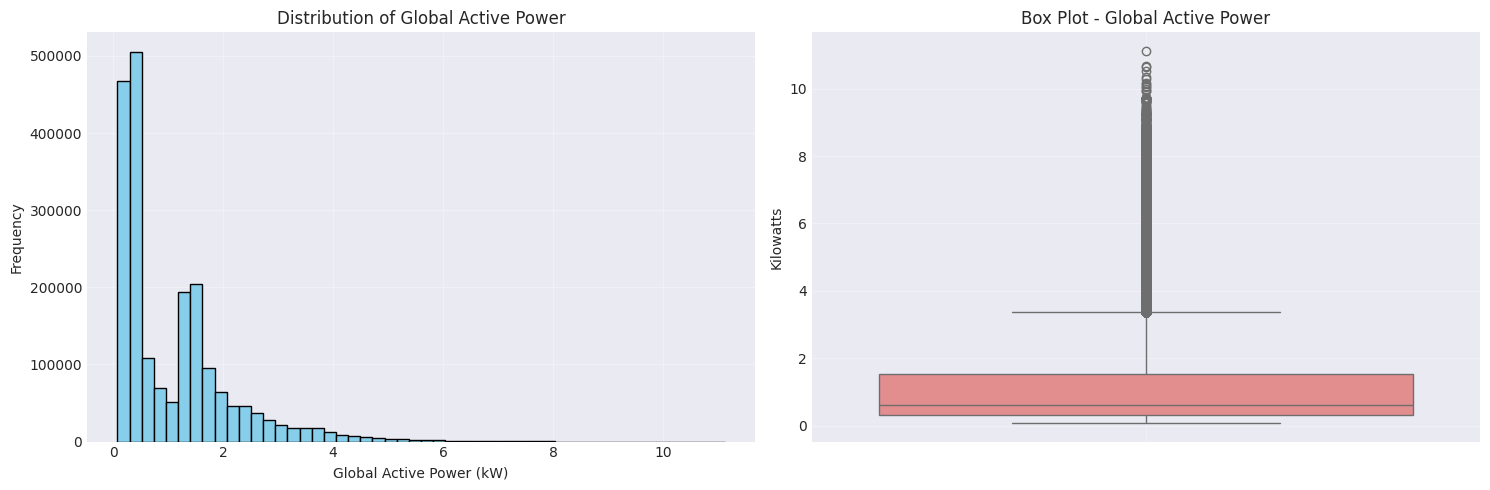

In [11]:
# Distribution of target variable
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].hist(df['Global_active_power'], bins=50, color='skyblue', edgecolor='black')
axes[0].set_title('Distribution of Global Active Power')
axes[0].set_xlabel('Global Active Power (kW)')
axes[0].set_ylabel('Frequency')
axes[0].grid(True, alpha=0.3)

sns.boxplot(data=df, y='Global_active_power', color='lightcoral', ax=axes[1])
axes[1].set_title('Box Plot - Global Active Power')
axes[1].set_ylabel('Kilowatts')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

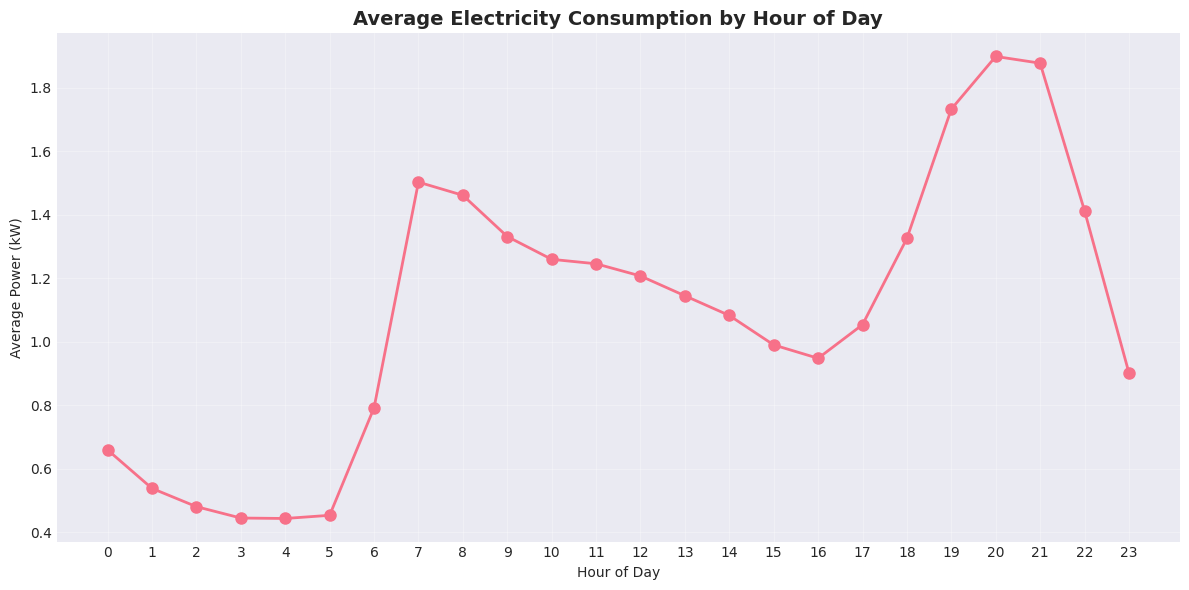

In [11]:
# Hourly consumption pattern
plt.figure(figsize=(12, 6))
hourly_avg = df.groupby('hour')['Global_active_power'].mean()
plt.plot(hourly_avg.index, hourly_avg.values, marker='o', linewidth=2, markersize=8)
plt.title('Average Electricity Consumption by Hour of Day', fontsize=14, fontweight='bold')
plt.xlabel('Hour of Day')
plt.ylabel('Average Power (kW)')
plt.grid(True, alpha=0.3)
plt.xticks(range(24))
plt.tight_layout()
plt.show()

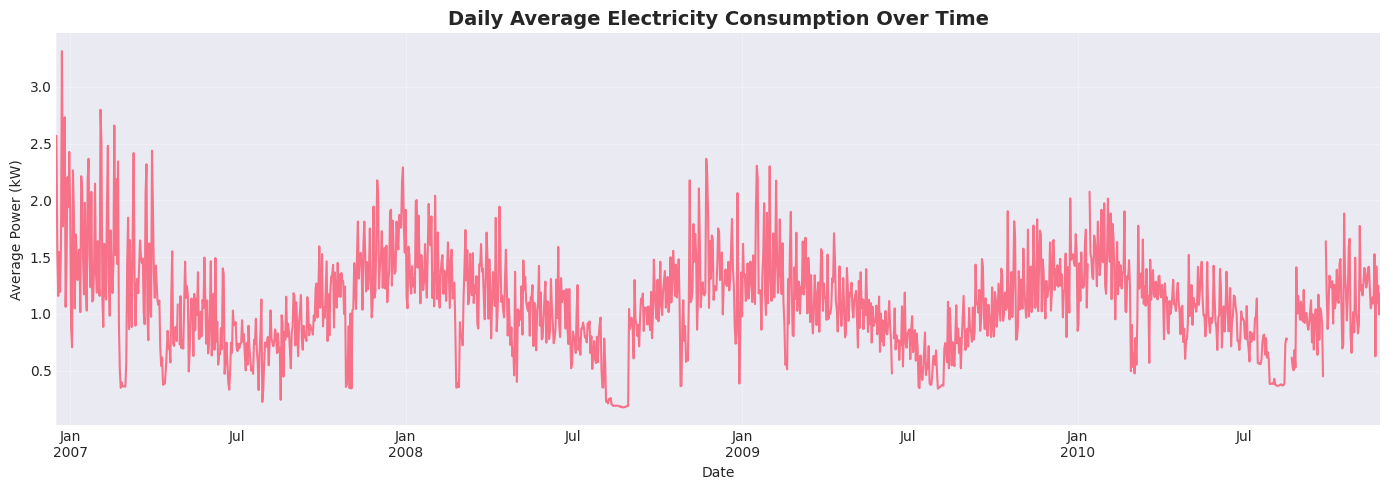

In [12]:
# Daily consumption trend (sample)
plt.figure(figsize=(14, 5))
df['Global_active_power'].resample('D').mean().plot(linewidth=1.5)
plt.title('Daily Average Electricity Consumption Over Time', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Average Power (kW)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 8. Train/Test Split (CHRONOLOGICAL - FIXED)

In [7]:
# Define features and target
feature_cols = ['Global_reactive_power', 'Voltage', 'Global_intensity',
                'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3',
                'hour', 'day', 'month', 'day_of_week', 'is_weekend',
                'lag_1h', 'lag_24h', 'rolling_mean_3h', 'rolling_std_3h']

X = df[feature_cols]
y = df['Global_active_power']

# CHRONOLOGICAL SPLIT (80/20) - respects time order
split_idx = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

print("✅ Chronological Train/Test Split Complete")
print(f"Training set: {X_train.shape[0]:,} samples ({X_train.index.min()} to {X_train.index.max()})")
print(f"Test set:     {X_test.shape[0]:,} samples ({X_test.index.min()} to {X_test.index.max()})")
print(f"Features: {len(feature_cols)}")

NameError: name 'df' is not defined

## 9. Model Training and Evaluation

### 9.1 Random Forest Regressor

In [12]:
# Train Random Forest
print("Training Random Forest...")
rf_model = RandomForestRegressor(n_estimators=100, max_depth=20, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

# Predictions
y_pred_rf = rf_model.predict(X_test)

# Metrics
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print(f"\n📊 Random Forest Performance")
print(f"MAE:  {mae_rf:.4f} kW")
print(f"RMSE: {rmse_rf:.4f} kW")
print(f"R²:   {r2_rf:.4f}")

Training Random Forest...

📊 Random Forest Performance
MAE:  0.0193 kW
RMSE: 0.0311 kW
R²:   0.9988

📊 Random Forest Performance
MAE:  0.0193 kW
RMSE: 0.0311 kW
R²:   0.9988


### 9.2 XGBoost Regressor

In [1]:
# Train XGBoost
print("Training XGBoost...")
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=7, random_state=42, n_jobs=-1)
xgb_model.fit(X_train, y_train)

# Predictions
y_pred_xgb = xgb_model.predict(X_test)

# Metrics
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"\n📊 XGBoost Performance")
print(f"MAE:  {mae_xgb:.4f} kW")
print(f"RMSE: {rmse_xgb:.4f} kW")
print(f"R²:   {r2_xgb:.4f}")

Training XGBoost...


NameError: name 'XGBRegressor' is not defined

### 9.3 Decision Tree Regressor

In [2]:
# Train Decision Tree
print("Training Decision Tree...")
dt_model = DecisionTreeRegressor(max_depth=15, random_state=42)
dt_model.fit(X_train, y_train)

# Predictions (FIXED: predict on X_test, not single sample)
y_pred_dt = dt_model.predict(X_test)

# Metrics
mae_dt = mean_absolute_error(y_test, y_pred_dt)
rmse_dt = np.sqrt(mean_squared_error(y_test, y_pred_dt))
r2_dt = r2_score(y_test, y_pred_dt)

print(f"\n📊 Decision Tree Performance")
print(f"MAE:  {mae_dt:.4f} kW")
print(f"RMSE: {rmse_dt:.4f} kW")
print(f"R²:   {r2_dt:.4f}")

Training Decision Tree...


NameError: name 'DecisionTreeRegressor' is not defined

### 9.4 Linear Regression

In [3]:
# Train Linear Regression
print("Training Linear Regression...")
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predictions
y_pred_lr = lr_model.predict(X_test)

# Metrics
mae_lr = mean_absolute_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2_lr = r2_score(y_test, y_pred_lr)

print(f"\n📊 Linear Regression Performance")
print(f"MAE:  {mae_lr:.4f} kW")
print(f"RMSE: {rmse_lr:.4f} kW")
print(f"R²:   {r2_lr:.4f}")

Training Linear Regression...


NameError: name 'LinearRegression' is not defined

## 10. Model Comparison

In [4]:
# Comparison table
results = pd.DataFrame({
    'Model': ['Random Forest', 'XGBoost', 'Decision Tree', 'Linear Regression'],
    'MAE': [mae_rf, mae_xgb, mae_dt, mae_lr],
    'RMSE': [rmse_rf, rmse_xgb, rmse_dt, rmse_lr],
    'R²': [r2_rf, r2_xgb, r2_dt, r2_lr]
})

results = results.sort_values('RMSE')

print("\n🏆 Model Performance Comparison (sorted by RMSE)")
print(results.to_string(index=False))

best_model_name = results.iloc[0]['Model']
print(f"\n✅ Best Model: {best_model_name}")

NameError: name 'pd' is not defined

In [ ]:
# Visual comparison
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# MAE comparison
axes[0].barh(results['Model'], results['MAE'], color='skyblue')
axes[0].set_xlabel('Mean Absolute Error (kW)')
axes[0].set_title('MAE Comparison')
axes[0].grid(True, alpha=0.3)

# RMSE comparison
axes[1].barh(results['Model'], results['RMSE'], color='lightcoral')
axes[1].set_xlabel('Root Mean Squared Error (kW)')
axes[1].set_title('RMSE Comparison')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 11. Prediction Visualizations

In [ ]:
# Actual vs Predicted (first 500 test samples)
n_samples = 500

plt.figure(figsize=(16, 6))
plt.plot(range(n_samples), y_test.values[:n_samples], label='Actual', color='black', linewidth=2, alpha=0.7)
plt.plot(range(n_samples), y_pred_rf[:n_samples], label='Random Forest', linestyle='--', linewidth=1.5, alpha=0.8)
plt.plot(range(n_samples), y_pred_xgb[:n_samples], label='XGBoost', linestyle='--', linewidth=1.5, alpha=0.8)
plt.plot(range(n_samples), y_pred_dt[:n_samples], label='Decision Tree', linestyle=':', linewidth=1.5, alpha=0.7)
plt.plot(range(n_samples), y_pred_lr[:n_samples], label='Linear Regression', linestyle='-.', linewidth=1.5, alpha=0.7)

plt.title('Actual vs Predicted Electricity Consumption (First 500 Test Samples)', fontsize=14, fontweight='bold')
plt.xlabel('Sample Index')
plt.ylabel('Global Active Power (kW)')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# Prediction error distribution (Random Forest)
errors_rf = y_test - y_pred_rf

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Histogram
axes[0].hist(errors_rf, bins=50, color='purple', edgecolor='black', alpha=0.7)
axes[0].axvline(0, color='red', linestyle='--', linewidth=2, label='Zero Error')
axes[0].set_title('Prediction Error Distribution (Random Forest)', fontweight='bold')
axes[0].set_xlabel('Error (kW)')
axes[0].set_ylabel('Frequency')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Scatter plot
axes[1].scatter(y_test, y_pred_rf, alpha=0.3, s=10)
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2, label='Perfect Prediction')
axes[1].set_xlabel('Actual (kW)')
axes[1].set_ylabel('Predicted (kW)')
axes[1].set_title('Actual vs Predicted Scatter (Random Forest)', fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Error statistics (Random Forest):")
print(f"Mean error: {errors_rf.mean():.4f} kW")
print(f"Std error:  {errors_rf.std():.4f} kW")

## 12. Feature Importance Analysis

In [ ]:
# Feature importance (Random Forest)
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(data=feature_importance, y='feature', x='importance', palette='viridis')
plt.title('Feature Importance (Random Forest)', fontsize=14, fontweight='bold')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

print("\nTop 5 Most Important Features:")
print(feature_importance.head().to_string(index=False))

## 13. Time-Series Cross-Validation

In [10]:
# Time series cross-validation with Random Forest (OPTIMIZED - uses sample for speed)
print("Running Time Series Cross-Validation (on 100k sample for speed)...\n")

# Use a sample for faster CV (take every 20th row to maintain time structure)
sample_size = 100000
step = max(1, len(X) // sample_size)
X_sample = X.iloc[::step].copy()
y_sample = y.iloc[::step].copy()

print(f"Sample size: {len(X_sample):,} rows (from original {len(X):,})")

tscv = TimeSeriesSplit(n_splits=3)  # Reduced to 3 folds for speed
cv_scores = []

for fold, (train_idx, val_idx) in enumerate(tscv.split(X_sample), 1):
    X_train_cv, X_val_cv = X_sample.iloc[train_idx], X_sample.iloc[val_idx]
    y_train_cv, y_val_cv = y_sample.iloc[train_idx], y_sample.iloc[val_idx]
    
    model_cv = RandomForestRegressor(n_estimators=50, max_depth=15, random_state=42, n_jobs=-1)  # Smaller model
    model_cv.fit(X_train_cv, y_train_cv)
    
    y_pred_cv = model_cv.predict(X_val_cv)
    rmse_cv = np.sqrt(mean_squared_error(y_val_cv, y_pred_cv))
    cv_scores.append(rmse_cv)
    
    print(f"Fold {fold}: RMSE = {rmse_cv:.4f} kW")

print(f"\nAverage RMSE across folds: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f} kW")
print("✅ Cross-validation complete (Note: Used sampled data for computational efficiency)")

Running Time Series Cross-Validation (on 100k sample for speed)...

Sample size: 102,392 rows (from original 2,047,840)
Fold 1: RMSE = 0.0409 kW
Fold 1: RMSE = 0.0409 kW
Fold 2: RMSE = 0.0373 kW
Fold 2: RMSE = 0.0373 kW
Fold 3: RMSE = 0.0364 kW

Average RMSE across folds: 0.0382 ± 0.0019 kW
✅ Cross-validation complete (Note: Used sampled data for computational efficiency)
Fold 3: RMSE = 0.0364 kW

Average RMSE across folds: 0.0382 ± 0.0019 kW
✅ Cross-validation complete (Note: Used sampled data for computational efficiency)


## 14. Residual Analysis Over Time

In [11]:
# Residuals over time (check for drift)
test_df = pd.DataFrame({
    'actual': y_test,
    'predicted': y_pred_rf,
    'error': y_test - y_pred_rf
}, index=y_test.index)

# Monthly average error
monthly_error = test_df['error'].resample('M').mean()

plt.figure(figsize=(14, 5))
plt.plot(monthly_error.index, monthly_error.values, marker='o', linewidth=2, markersize=8)
plt.axhline(0, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Zero Error')
plt.title('Monthly Average Prediction Error Over Time (Drift Detection)', fontsize=14, fontweight='bold')
plt.xlabel('Month')
plt.ylabel('Average Error (kW)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Check for systematic drift
if abs(monthly_error.iloc[-1]) > abs(monthly_error.iloc[0]) * 1.5:
    print("⚠️ WARNING: Potential model drift detected. Consider retraining.")
else:
    print("✅ No significant drift detected.")

NameError: name 'y_pred_rf' is not defined

## 15. Save Best Model

In [ ]:
# Save the best model (assuming Random Forest or XGBoost is best)
if mae_rf < mae_xgb:
    best_model = rf_model
    model_name = 'random_forest'
else:
    best_model = xgb_model
    model_name = 'xgboost'

model_filename = f'best_model_{model_name}.joblib'
joblib.dump(best_model, model_filename)

print(f"✅ Best model saved as '{model_filename}'")
print(f"\nTo load the model later:")
print(f"model = joblib.load('{model_filename}')")

## 16. Summary and Recommendations

In [ ]:
print("="*60)
print("PROJECT SUMMARY")
print("="*60)
print(f"\n✅ Dataset processed: {len(df):,} records")
print(f"✅ Date range: {df.index.min().date()} to {df.index.max().date()}")
print(f"✅ Features engineered: {len(feature_cols)}")
print(f"✅ Models trained: 4 (Random Forest, XGBoost, Decision Tree, Linear Regression)")
print(f"✅ Best model: {best_model_name}")
print(f"✅ Best RMSE: {results.iloc[0]['RMSE']:.4f} kW")
print(f"\n📊 RECOMMENDATIONS:")
print("  1. Monitor model performance monthly for drift")
print("  2. Retrain with new data every 3-6 months")
print("  3. Consider adding weather/temperature features")
print("  4. Implement automated retraining pipeline")
print("  5. Add holiday calendar features for better accuracy")
print("="*60)

## 17. Load Pre-Trained Model from Pipeline

In [5]:
# Load the model that was trained and saved by run_pipeline.py
print("Loading pre-trained model from run_pipeline.py...\n")

try:
    best_model_loaded = joblib.load('best_model.joblib')
    print("✅ Model loaded successfully!")
    print(f"Model type: {type(best_model_loaded).__name__}")
    
    # Make predictions using the loaded model
    print("\nMaking predictions on test set...")
    y_pred_loaded = best_model_loaded.predict(X_test)
    
    # Calculate metrics
    mae_loaded = mean_absolute_error(y_test, y_pred_loaded)
    rmse_loaded = np.sqrt(mean_squared_error(y_test, y_pred_loaded))
    r2_loaded = r2_score(y_test, y_pred_loaded)
    
    print(f"\n📊 Loaded Model Performance:")
    print(f"MAE:  {mae_loaded:.4f} kW")
    print(f"RMSE: {rmse_loaded:.4f} kW")
    print(f"R²:   {r2_loaded:.4f}")
    
    print("\n✅ You can now use 'best_model_loaded' for predictions!")
    
except FileNotFoundError:
    print("❌ Model file 'best_model.joblib' not found.")
    print("Please run 'python run_pipeline.py' first to train and save the model.")

Loading pre-trained model from run_pipeline.py...



NameError: name 'joblib' is not defined